
### SEE POST_PNA.ipynb for a more complete exploration of a similar problem

# Purpose Statement

This Notebook Introduces how to download our Benchmark datasets and a single benchmark method for post-processing an Ensemble forecast (EMOS), it corrects the forecast of the MJO from multiple modeling centers. Please see their paper for an exploration of the EMOS system we use here, and other interesting methods for post-process bench marking. A brief description is also below:


#### Ensemble Model Output Statistics (EMOS)

---
Ensemble Model Output Statistics post-processing  is a non-homogeneous regression which (EMOS; Gneiting et al., 2005), relies on parametric forecast distributions. One specifies a predictive distribution and estimate its parameters. In the EMOS framework the distribution parameters are connected to summary statistics of the ensemble predictions through suitable link functions which are estimated by minimizing a probabilistic loss function over a training dataset. We will utilize the KERAS training framework in order to specify and learn this linking function. 

#### CRPS as a 'Proper Scoring' Metric for Ensemble Evaluation
----

We use CRPS as a scoring metric to evaluate the Ensemble predictions. We are assuming a parametric normal distribution for the PNA forecast and applying the CRPS methods as seen in Rasp & Lerch 2018 appendix.

See Rasp & Lerch for an evaluation of CRPS as a Proper scoring metric 

Paper URL: [Rasp & Lerch 2018](https://arxiv.org/abs/1805.09091)
## Import Necessary Packages:

In [30]:
import numpy as np
import pandas as pd
import glob
import os
import math
import matplotlib.pyplot as plt
from datetime import datetime
from datetime import timedelta
import time
import xarray as xr
from netCDF4 import Dataset

import keras
from keras.layers import Input, Dense, merge, Embedding, Flatten, Concatenate,Conv2D,BatchNormalization,Dropout,MaxPooling2D
from keras.models import Model, Sequential
from keras.optimizers import Adam, SGD
import keras.backend as K
from keras.callbacks import EarlyStopping

from cartopy import config
import cartopy.crs as ccrs
import cartopy.feature as cf
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import palettable

import random 
random.seed(1) #for reproduceability. 
import matplotlib.ticker as mticker
from sklearn import datasets, linear_model, metrics 
# import utils

if keras.backend.backend() == 'tensorflow':
    from tensorflow import erf
else:
    from theano.tensor import erf
    
import seaborn as sns
sns.set_style('whitegrid', {'font.family':'serif', 'font.serif':'Times New Roman'})

# import utils

## Helpful functions


In [31]:
def crps_cost_function(y_true, y_pred, theano=False):
    """Compute the CRPS cost function for a normal distribution defined by
    the mean and standard deviation.
    Code inspired by Kai Polsterer (HITS).
    Args:
        y_true: True values
        y_pred: Tensor containing predictions: [mean, std]
        theano: Set to true if using this with pure theano.
    Returns:
        mean_crps: Scalar with mean CRPS over batch
    """

    # Split input
    mu = y_pred[:, 0]
    sigma = y_pred[:, 1]
    # Ugly workaround for different tensor allocation in keras and theano
    if not theano:
        y_true = y_true[:, 0]   # Need to also get rid of axis 1 to match!

    # To stop sigma from becoming negative we first have to 
    # convert it the the variance and then take the square
    # root again. 
    var = K.square(sigma)
    # The following three variables are just for convenience
    loc = (y_true - mu) / K.sqrt(var)
    phi = 1.0 / np.sqrt(2.0 * np.pi) * K.exp(-K.square(loc) / 2.0)
    Phi = 0.5 * (1.0 + erf(loc / np.sqrt(2.0)))
    # First we will compute the crps for each input/target pair
    crps =  K.sqrt(var) * (loc * (2. * Phi - 1.) + 2 * phi - 1. / np.sqrt(np.pi))
    # Then we take the mean. The cost is now a scalar
    return K.mean(crps)



def crps_(y_true, y_pred):
    """Compute the CRPS cost function for a normal distribution defined by
    the mean and standard deviation.
    Code inspired by Kai Polsterer (HITS).
    Args:
        y_true: True values
        y_pred: Tensor containing predictions: [mean, std]
        theano: Set to true if using this with pure theano.
    Returns:
        mean_crps: Scalar with mean CRPS over batch
    """

    # Split input
    mu = y_pred[:, 0]
    sigma = y_pred[:, 1]
    # Ugly workaround for different tensor allocation in keras and theano

    # To stop sigma from becoming negative we first have to 
    # convert it the the variance and then take the square
    # root again. 
    var = np.square(sigma)
    # The following three variables are just for convenience
    loc = (y_true - mu) / np.sqrt(var)
    phi = 1.0 / np.sqrt(2.0 * np.pi) * np.exp(-np.square(loc) / 2.0)
    Phi = 0.5 * (1.0 + math.erf(loc / np.sqrt(2.0)))
    # First we will compute the crps for each input/target pair
    crps =  np.sqrt(var) * (loc * (2. * Phi - 1.) + 2 * phi - 1. / np.sqrt(np.pi))
    # Then we take the mean. The cost is now a scalar
    return np.mean(crps)




def build_EMOS_network_keras(compile=False, optimizer='sgd', lr=0.1):
    """Build (and maybe compile) EMOS network in keras.
    Args:
        compile: If true, compile model
        optimizer: String of keras optimizer
        lr: learning rate
    Returns:
        model: Keras model
    """
    mean_in = Input(shape=(1,))
    std_in = Input(shape=(1,))
    mean_out = Dense(1, activation='linear')(mean_in)
    std_out = Dense(1, activation='linear')(std_in)
    x = keras.layers.concatenate([mean_out, std_out], axis=1)
    model = Model(inputs=[mean_in, std_in], outputs=x)

    if compile:
        opt = keras.optimizers.__dict__[optimizer](lr=lr)
        model.compile(optimizer=opt, loss=crps_cost_function)
    return model



def build_NN_network_keras(compile=False, optimizer='sgd', lr=0.1):
    """Build (and maybe compile) EMOS network in keras.
    Args:
        compile: If true, compile model
        optimizer: String of keras optimizer
        lr: learning rate
    Returns:
        model: Keras model
    """
    mean_in = Input(shape=(1,))
    std_in = Input(shape=(1,))
    mean_out = Dense(1, activation='relu')(mean_in)
    std_out = Dense(1, activation='relu')(std_in)
    x = keras.layers.concatenate([mean_out, std_out], axis=1)
    
    D1 = Dense(10, activation='relu')(x)
    D2 = Dense(2, activation='linear')(D1)
    
    model = Model(inputs=[mean_in, std_in], outputs=D2)

    if compile:
        opt = keras.optimizers.__dict__[optimizer](lr=lr)
        model.compile(optimizer=opt, loss=crps_cost_function)
    return model

In [32]:
data_path = os.environ['POST_PROCESS_FORECASTS_DATA']
AllDat = xr.open_zarr(os.path.join(data_path,'MJO_CPTECzar'))
AllDat

<xarray.Dataset>
Dimensions:        (index: 985812)
Coordinates:
  * index          (index) int64 0 1 2 3 4 ... 985808 985809 985810 985811
Data variables:
    Center         (index) object dask.array<chunksize=(61614,), meta=np.ndarray>
    Ense           (index) int64 dask.array<chunksize=(61614,), meta=np.ndarray>
    Forecast_Date  (index) int64 dask.array<chunksize=(61614,), meta=np.ndarray>
    Forecast_Lead  (index) int64 dask.array<chunksize=(61614,), meta=np.ndarray>
    RMM1           (index) float64 dask.array<chunksize=(61614,), meta=np.ndarray>
    RMM1_Analysis  (index) float64 dask.array<chunksize=(61614,), meta=np.ndarray>
    RMM2           (index) float64 dask.array<chunksize=(61614,), meta=np.ndarray>
    RMM2_Analysis  (index) float64 dask.array<chunksize=(61614,), meta=np.ndarray>

In [33]:
df=AllDat.to_dataframe()

In [34]:
df.loc[df.RMM1_Analysis>=-10]

,Center,Ense,Forecast_Date,Forecast_Lead,RMM1,RMM1_Analysis,RMM2,RMM2_Analysis
index,,,,,,,,
0,CPTEC,0,2008020112,0,0.78186,0.781860,-1.40700,-1.407004
1,CPTEC,0,2008020112,1,1.10752,1.249189,-1.36873,-1.278959
2,CPTEC,0,2008020112,2,1.34058,1.305825,-1.30573,-1.131814
3,CPTEC,0,2008020112,3,1.50672,1.559831,-1.06140,-1.045375
4,CPTEC,0,2008020112,4,1.40641,1.741814,-0.51176,-0.753643
...,...,...,...,...,...,...,...,...
985807,CPTEC,14,2019123112,11,0.87630,0.000000,1.37740,0.000000
985808,CPTEC,14,2019123112,12,0.40639,0.000000,1.74124,0.000000
985809,CPTEC,14,2019123112,13,0.01107,0.000000,1.39712,0.000000


In [35]:
#find all the PNA forecasts... 
MJO_zarrs = sorted(glob.glob(os.path.join(data_path,"MJO_*")))

leadtime=10 #Lead time to assess
monthz = [12,1,2,3] #months to calculate for
#loop through and calculate the CRPS of the 2019-2020 season.. except UKMO no data for 2014->:

#crps dictionary
crpsdict = dict()


for zarr in MJO_zarrs[:-1]:
    print('Examining',zarr)
    AllDat = xr.open_zarr(zarr)
    AllDat=AllDat.to_dataframe()
    AllDat = AllDat.dropna()
    AllDat = AllDat[AllDat.RMM1<20]
    AllDat = AllDat[AllDat.RMM1_Analysis<=10]
    
    #subset lead time:
    AllDatLead = AllDat.loc[AllDat['Forecast_Lead']==leadtime]
    
    #insert month/day/year columns for book keeping. 
    dayz = []
    mons = []
    yrs = []
    
    for bb,dat in enumerate((AllDatLead['Forecast_Date'])):
        datetime_object = datetime.strptime(str(dat), '%Y%m%d%H')
        yrs.append(datetime_object.year)
        mons.append(datetime_object.month)
        dayz.append(datetime_object.day)
    
    #insert month/day/year columns for book keeping. 
    AllDatLead.insert(6,'day',dayz)
    AllDatLead.insert(7,'month',mons)
    AllDatLead.insert(8,'year',yrs)
    
    if len(monthz)==1:
        AllDatMon = AllDatLead.loc[AllDatLead['month'] == monthz[0]]
    else:
        AllDatMon = AllDatLead.loc[AllDatLead['month'] == monthz[0]]
        for mm in monthz[1:]:
            AllDatMon = AllDatMon.append(AllDatLead.loc[AllDatLead['month'] == mm])

    #create mean and standard deviation for the Ensemble forecast: 
    MJO_mean=[]
    MJO_std=[]
    MJO_obs=[]
    For_Date=[]
    yz=[]
    mz=[]
    dz=[]

    for nn,dat in enumerate(np.unique(AllDatMon['Forecast_Date'])):
        tt = AllDatMon[AllDatMon.Forecast_Date==dat].RMM1
        MJO_mean.append(np.mean(AllDatMon[AllDatMon.Forecast_Date==dat].RMM1))
        MJO_std.append(np.std(AllDatMon[AllDatMon.Forecast_Date==dat].RMM1))
        MJO_obs.append(np.mean(AllDatMon[AllDatMon.Forecast_Date==dat].RMM1_Analysis))
        dz.append(np.mean(AllDatMon[AllDatMon.Forecast_Date==dat].day))
        mz.append(np.mean(AllDatMon[AllDatMon.Forecast_Date==dat].month))
        yz.append(np.mean(AllDatMon[AllDatMon.Forecast_Date==dat].year))
        For_Date.append(dat)

    
    d = {'MJO_mean': MJO_mean, 'MJO_std': MJO_std,'MJO_obs':MJO_obs,'Fore_Date':For_Date,
     'day':dz,'month':mz,'year':yz}
    MJOdf  = pd.DataFrame(data=d)
    
    MJOdf = MJOdf[(MJOdf.year>=2015)]
    
    crps=[]
    print('...calc crps...')
    for nn in range(len(MJOdf)):
        
        MODmjo_pred = (np.array([MJOdf.MJO_mean.iloc[nn],MJOdf.MJO_std.iloc[nn]]))
        crps_mod= crps_(np.expand_dims([MJOdf['MJO_obs'].iloc[nn]],axis=1),
                                                np.transpose(np.expand_dims(np.array(MODmjo_pred),axis=1)))

        crps.append(crps_mod)
    cent = zarr.split('MJO_')[1]
    cent = cent.split('zar')[0]
    crpsdict[cent] = crps

Examining /Volumes/d1/bpetzke/work/misc/PostProcessForecasts/All_Zarr/MJO_CMAzar
...calc crps...
Examining /Volumes/d1/bpetzke/work/misc/PostProcessForecasts/All_Zarr/MJO_CMCzar
...calc crps...
Examining /Volumes/d1/bpetzke/work/misc/PostProcessForecasts/All_Zarr/MJO_CPTECzar


/Users/bpetzke/anaconda3/envs/post_process_forecasts/lib/python3.6/site-packages/ipykernel_launcher.py:57: RuntimeWarning: divide by zero encountered in true_divide
/Users/bpetzke/anaconda3/envs/post_process_forecasts/lib/python3.6/site-packages/ipykernel_launcher.py:61: RuntimeWarning: invalid value encountered in multiply


...calc crps...
Examining /Volumes/d1/bpetzke/work/misc/PostProcessForecasts/All_Zarr/MJO_ECMWFzar
...calc crps...
Examining /Volumes/d1/bpetzke/work/misc/PostProcessForecasts/All_Zarr/MJO_JMAzar
...calc crps...
Examining /Volumes/d1/bpetzke/work/misc/PostProcessForecasts/All_Zarr/MJO_KMAzar
...calc crps...
Examining /Volumes/d1/bpetzke/work/misc/PostProcessForecasts/All_Zarr/MJO_NCEPzar
...calc crps...


/Users/bpetzke/anaconda3/envs/post_process_forecasts/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:1316: RuntimeWarning: invalid value encountered in less_equal
  wiskhi = x[x <= hival]
/Users/bpetzke/anaconda3/envs/post_process_forecasts/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:1323: RuntimeWarning: invalid value encountered in greater_equal
  wisklo = x[x >= loval]
/Users/bpetzke/anaconda3/envs/post_process_forecasts/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:1331: RuntimeWarning: invalid value encountered in less
  x[x < stats['whislo']],
/Users/bpetzke/anaconda3/envs/post_process_forecasts/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:1332: RuntimeWarning: invalid value encountered in greater
  x[x > stats['whishi']],


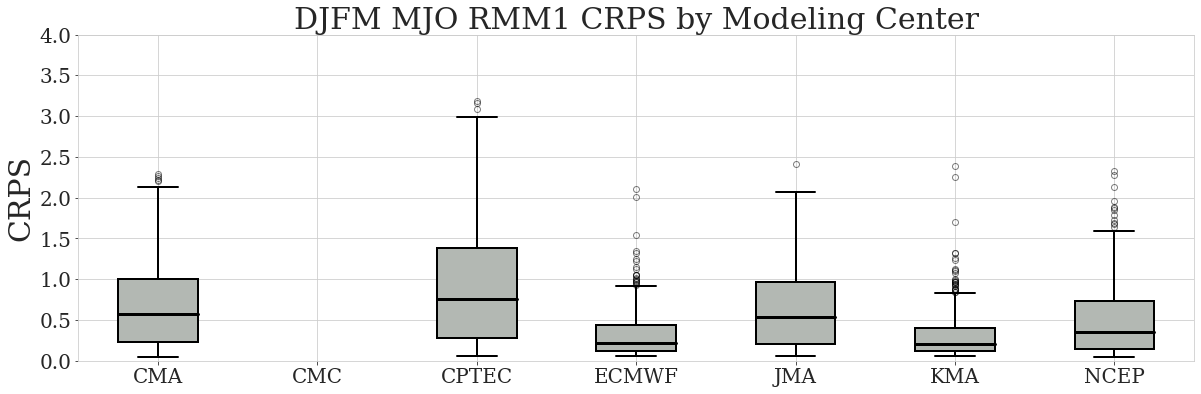

In [36]:
data_to_plot=[crpsdict['CMA'],crpsdict['CMC'],crpsdict['CPTEC'],crpsdict['ECMWF'],
              crpsdict['JMA'],crpsdict['KMA'],crpsdict['NCEP']]


fig = plt.figure(1, figsize=(20, 6))

# Create an axes instance
ax = fig.add_subplot(111)
## add patch_artist=True option to ax.boxplot() 
## to get fill color
bp = ax.boxplot(data_to_plot, patch_artist=True)

## change outline color, fill color and linewidth of the boxes
for box in bp['boxes']:
    # change outline color
    box.set( color='k', linewidth=2)
    # change fill color
    box.set( facecolor = [0.7,0.72,0.7] )

## change color and linewidth of the whiskers
for whisker in bp['whiskers']:
    whisker.set(color='k', linewidth=2)

## change color and linewidth of the caps
for cap in bp['caps']:
    cap.set(color='k', linewidth=2)

## change color and linewidth of the medians
for median in bp['medians']:
    median.set(color='k', linewidth=3)

## change the style of fliers and their fill
for flier in bp['fliers']:
    flier.set(marker='o', color='k', alpha=0.5)
    
plt.ylim([0,4])
ax.set_xticklabels(crpsdict.keys(),fontsize=20)
ax.set_yticklabels(np.arange(0,4.5,0.5),fontsize=20)


ax.get_xaxis().tick_bottom()
ax.get_yaxis().tick_left()

plt.title('DJFM MJO RMM1 CRPS by Modeling Center',fontsize=30)
plt.ylabel('CRPS',fontsize=30)

# fname = '/Users/will/Desktop/Haupt/CRPS_MJO_Center.png'
# plt.savefig(fname, dpi=300, facecolor='w', edgecolor='w',
#         orientation='portrait', papertype=None, format=None,
#         transparent=False, bbox_inches='tight', pad_inches=0.1,
#         frameon=None, metadata=None)
plt.show()



In [37]:
AllDat = xr.open_zarr(MJO_zarrs[2])
AllDat=AllDat.to_dataframe()
AllDat = AllDat.dropna()
AllDat = AllDat.dropna()
AllDat = AllDat[AllDat.RMM1<20]
AllDat = AllDat[AllDat.RMM1_Analysis<=10]
    #subset lead time:
AllDatLead = AllDat.loc[AllDat['Forecast_Lead']==leadtime]
    
    #insert month/day/year columns for book keeping. 
dayz = []
mons = []
yrs = []
    
for bb,dat in enumerate((AllDatLead['Forecast_Date'])):
    datetime_object = datetime.strptime(str(dat), '%Y%m%d%H')
    yrs.append(datetime_object.year)
    mons.append(datetime_object.month)
    dayz.append(datetime_object.day)
    
    #insert month/day/year columns for book keeping. 
AllDatLead.insert(6,'day',dayz)
AllDatLead.insert(7,'month',mons)
AllDatLead.insert(8,'year',yrs)

if len(monthz)==1:
    AllDatMon = AllDatLead.loc[AllDatLead['month'] == monthz[0]]
else:
    AllDatMon = AllDatLead.loc[AllDatLead['month'] == monthz[0]]
    for mm in monthz[1:]:
        AllDatMon = AllDatMon.append(AllDatLead.loc[AllDatLead['month'] == mm])

#create mean and standard deviation for the Ensemble forecast: 
MJO_mean=[]
MJO_std=[]
MJO_obs=[]
For_Date=[]
yz=[]
mz=[]
dz=[]

for nn,dat in enumerate(np.unique(AllDatMon['Forecast_Date'])):
    tt = AllDatMon[AllDatMon.Forecast_Date==dat].RMM1
    MJO_mean.append(np.mean(AllDatMon[AllDatMon.Forecast_Date==dat].RMM1))
    MJO_std.append(np.std(AllDatMon[AllDatMon.Forecast_Date==dat].RMM1))
    MJO_obs.append(np.mean(AllDatMon[AllDatMon.Forecast_Date==dat].RMM1_Analysis))
    dz.append(np.mean(AllDatMon[AllDatMon.Forecast_Date==dat].day))
    mz.append(np.mean(AllDatMon[AllDatMon.Forecast_Date==dat].month))
    yz.append(np.mean(AllDatMon[AllDatMon.Forecast_Date==dat].year))
    For_Date.append(dat)
    
d = {'MJO_mean': MJO_mean, 'MJO_std': MJO_std,'MJO_obs':MJO_obs,'Fore_Date':For_Date,
     'day':dz,'month':mz,'year':yz}
MJOdf  = pd.DataFrame(data=d)


crps=[]
print('...calc crps...')
for nn in range(len(MJOdf)):
        
    MODmjo_pred = (np.array([MJOdf.MJO_mean.iloc[nn],MJOdf.MJO_std.iloc[nn]]))
    crps_mod= crps_(np.expand_dims([MJOdf['MJO_obs'].iloc[nn]],axis=1),
                                                np.transpose(np.expand_dims(np.array(MODmjo_pred),axis=1)))

    crps.append(crps_mod)

cent = zarr.split('MJO_')[1]
cent = cent.split('zar')[0]
crpsdict[cent] = crps

...calc crps...


## Split into train test validate

In [38]:
MJO_train = MJOdf[MJOdf.year<=2017]
MJO_validate = MJOdf[(MJOdf.year>=2018)&(MJOdf.year<2019)]
MJO_test = MJOdf[(MJOdf.year>=2019)]

In [39]:
MODpna_pred = np.transpose(np.array([MJO_test.MJO_mean,MJO_test.MJO_std]))
crps_mod= keras.backend.eval(crps_cost_function(np.expand_dims(MJO_test['MJO_obs'],axis=1),MODpna_pred))
crps_mod

0.8367234114053789

In [40]:
xm=np.array(MJO_train['MJO_mean'])
xs=np.array(MJO_train['MJO_std'])
y=np.array(MJO_train['MJO_obs'])

xm_v=np.array(MJO_validate['MJO_mean'])
xs_v=np.array(MJO_validate['MJO_std'])
y_v=np.array(MJO_validate['MJO_obs'])

xm_t=np.array(MJO_test['MJO_mean'])
xs_t=np.array(MJO_test['MJO_std'])
y_t=np.array(MJO_test['MJO_obs'])

## Build the EMOS System

In [41]:
emos = build_EMOS_network_keras(compile=True, optimizer='sgd', lr=0.1)
emos.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
dense_7 (Dense)                 (None, 1)            2           input_5[0][0]                    
__________________________________________________________________________________________________
dense_8 (Dense)                 (None, 1)            2           input_6[0][0]                    
____________________________________________________________________________________________

In [42]:
bn=20
epcs=100
#### KERAS CALLBACKS TO ADD to Training######
filp = '/where/your/best/model/is/saved'
svbst = keras.callbacks.callbacks.ModelCheckpoint(filp, monitor='val_loss', 
                                                  verbose=1, save_best_only=True, save_weights_only=False)
#add this to the callbacks in fit function to save the best model on your personal machine. 

earlystop = keras.callbacks.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, 
                                                    verbose=1, mode='auto', restore_best_weights=True) 
rdclr = keras.callbacks.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, verbose=1, 
                                                    mode='auto', min_delta=0.0001, cooldown=0, min_lr=0)

#### Fitting the Model ######
emos.fit([xm,xs],y,batch_size=bn,validation_data=[[xm_v,xs_v],y_v],epochs=epcs,callbacks=[earlystop,rdclr])

Train on 1083 samples, validate on 115 samples
Epoch 1/100
1083/1083 [==============================] - 0s 206us/step - loss: 0.5819 - val_loss: 0.8092
Epoch 2/100
1083/1083 [==============================] - 0s 42us/step - loss: 0.5252 - val_loss: 0.7729
Epoch 3/100
1083/1083 [==============================] - 0s 41us/step - loss: 0.5226 - val_loss: 0.7717
Epoch 4/100
1083/1083 [==============================] - 0s 38us/step - loss: 0.5236 - val_loss: 0.7674
Epoch 5/100
1083/1083 [==============================] - 0s 38us/step - loss: 0.5235 - val_loss: 0.7704
Epoch 6/100
1083/1083 [==============================] - 0s 38us/step - loss: 0.5238 - val_loss: 0.7676
Epoch 7/100
1083/1083 [==============================] - 0s 39us/step - loss: 0.5223 - val_loss: 0.7719
Epoch 8/100
1083/1083 [==============================] - 0s 44us/step - loss: 0.5229 - val_loss: 0.7707
Epoch 9/100
1083/1083 [==============================] - 0s 39us/step - loss: 0.5232 - val_loss: 0.7687

Epoch 00009: Re

In [43]:
preds = emos.predict([xm_t, xs_t])

In [44]:
d = {'Forecast_Time': MJO_test.Fore_Date,'Obs': MJO_test.MJO_obs,'Emos_mean': preds[:,0],'Emos_std': preds[:,1],
    'Model_mean':MJO_test.MJO_mean,'Model_std':MJO_test.MJO_std}
results_df = pd.DataFrame(d)
#Sorting DataFrame by time and Station ID
results_df

,Forecast_Time,Obs,Emos_mean,Emos_std,Model_mean,Model_std
1198,2019010112,-0.871463,0.519670,-1.127468,0.138686,0.585926
1199,2019010212,-0.777311,0.259277,-1.070271,-0.375777,0.512169
1200,2019010312,-0.349831,0.166213,-1.015582,-0.559644,0.441645
1201,2019010412,0.070186,0.379312,-1.093124,-0.138622,0.541639
1202,2019010512,0.321753,0.279191,-1.130264,-0.336432,0.589531
...,...,...,...,...,...,...
1273,2019122712,0.000000,0.988376,-1.096929,1.064713,0.546545
1274,2019122812,0.000000,1.225068,-0.980487,1.532347,0.396390
1275,2019122912,0.000000,0.951677,-0.981586,0.992207,0.397807
1276,2019123012,0.000000,1.156706,-0.945648,1.397283,0.351463


In [45]:
crps_preds = emos.evaluate([xm_t,xs_t],y_t)
#jump through hoops to get data in the right form for loss function:
MODpna_pred = np.transpose(np.array([results_df.Model_mean,results_df.Model_std]))
crps_mod= keras.backend.eval(crps_cost_function(np.expand_dims(y_t,axis=1),MODpna_pred))

80/80 [==============================] - 0s 35us/step


In [46]:
print('Post-Processed with EMOS = CRPS:',crps_preds)
print('Raw Ensemble a Global = CRPS:',crps_mod)

Post-Processed with EMOS = CRPS: 0.4212238311767578
Raw Ensemble a Global = CRPS: 0.8367234114053789


## Neural Net

In [47]:
NN = build_NN_network_keras(compile=True, optimizer='sgd', lr=0.1)
NN.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
input_8 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
dense_9 (Dense)                 (None, 1)            2           input_7[0][0]                    
__________________________________________________________________________________________________
dense_10 (Dense)                (None, 1)            2           input_8[0][0]                    
____________________________________________________________________________________________

In [48]:
bn=30
epcs=100
#### KERAS CALLBACKS TO ADD to Training######
filp = '/where/your/best/model/is/saved'
svbst = keras.callbacks.callbacks.ModelCheckpoint(filp, monitor='val_loss', 
                                                  verbose=1, save_best_only=True, save_weights_only=False)
#add this to the callbacks in fit function to save the best model on your personal machine. 

earlystop = keras.callbacks.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=20, 
                                                    verbose=1, mode='auto', restore_best_weights=True) 
rdclr = keras.callbacks.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1, 
                                                    mode='auto', min_delta=0.0001, cooldown=0, min_lr=0)

#### Fitting the Model ######
NN.fit([xm,xs],y,batch_size=bn,validation_data=[[xm_v,xs_v],y_v],epochs=epcs,callbacks=[earlystop,rdclr])

Train on 1083 samples, validate on 115 samples
Epoch 1/100
1083/1083 [==============================] - 0s 242us/step - loss: nan - val_loss: nan
Epoch 2/100
1083/1083 [==============================] - 0s 34us/step - loss: nan - val_loss: nan
Epoch 3/100
1083/1083 [==============================] - 0s 31us/step - loss: nan - val_loss: nan

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.010000000149011612.
Epoch 4/100
1083/1083 [==============================] - 0s 33us/step - loss: nan - val_loss: nan
Epoch 5/100
1083/1083 [==============================] - 0s 32us/step - loss: nan - val_loss: nan
Epoch 6/100
1083/1083 [==============================] - 0s 34us/step - loss: nan - val_loss: nan

Epoch 00006: ReduceLROnPlateau reducing learning rate to 0.0009999999776482583.
Epoch 7/100
1083/1083 [==============================] - 0s 31us/step - loss: nan - val_loss: nan
Epoch 8/100
1083/1083 [==============================] - 0s 31us/step - loss: nan - val_loss: nan
Epoch 9

TypeError: 'NoneType' object is not subscriptable

In [49]:
#make a prediction:
predsE = emos.predict([xm_t, xs_t])
preds = NN.predict([xm_t, xs_t])

d = {'Forecast_Time': MJO_test.Fore_Date,'Obs': MJO_test.MJO_obs,'NN_mean': preds[:,0],'NN_std': preds[:,1],
    'EMOS_mean':predsE[:,0],'EMOS_std':predsE[:,1],'Model_mean':MJO_test.MJO_mean,'Model_std':MJO_test.MJO_std}
results_df = pd.DataFrame(d)
#Sorting DataFrame by time and Station ID
results_df

,Forecast_Time,Obs,NN_mean,NN_std,EMOS_mean,EMOS_std,Model_mean,Model_std
1198,2019010112,-0.871463,NaN,NaN,0.519670,-1.127468,0.138686,0.585926
1199,2019010212,-0.777311,NaN,NaN,0.259277,-1.070271,-0.375777,0.512169
1200,2019010312,-0.349831,NaN,NaN,0.166213,-1.015582,-0.559644,0.441645
1201,2019010412,0.070186,NaN,NaN,0.379312,-1.093124,-0.138622,0.541639
1202,2019010512,0.321753,NaN,NaN,0.279191,-1.130264,-0.336432,0.589531
...,...,...,...,...,...,...,...,...
1273,2019122712,0.000000,NaN,NaN,0.988376,-1.096929,1.064713,0.546545
1274,2019122812,0.000000,NaN,NaN,1.225068,-0.980487,1.532347,0.396390
1275,2019122912,0.000000,NaN,NaN,0.951677,-0.981586,0.992207,0.397807
1276,2019123012,0.000000,NaN,NaN,1.156706,-0.945648,1.397283,0.351463


In [50]:
crps_preds = NN.evaluate([xm_t,xs_t],y_t)
#jump through hoops to get data in the right form for loss function:
MODpna_pred = np.transpose(np.array([results_df.Model_mean,results_df.Model_std]))
crps_mod= keras.backend.eval(crps_cost_function(np.expand_dims(y_t,axis=1),MODpna_pred))

80/80 [==============================] - 0s 55us/step


In [51]:
print('Post-Processed with NN = CRPS:',crps_preds)
print('Raw Ensemble a Global = CRPS:',crps_mod)

Post-Processed with NN = CRPS: nan
Raw Ensemble a Global = CRPS: 0.8367234114053789


In [52]:
#EMOS vs. RAW vs. NN
crps_m = []
crps_p = []
crps_e = []

for nn in range(len(results_df)):
    MODpna_pred = (np.array([results_df.Model_mean.iloc[nn],results_df.Model_std.iloc[nn]]))
    crps_mod= crps_(np.expand_dims([results_df['Obs'].iloc[nn]],axis=1),
                                                np.transpose(np.expand_dims(np.array(MODpna_pred),axis=1)))
    
    crps_m.append(crps_mod)
    
    MODpna_pred = (np.array([results_df.NN_mean.iloc[nn],results_df.NN_std.iloc[nn]]))
    crps_pp=crps_(np.expand_dims([results_df['Obs'].iloc[nn]],axis=1),
                                                np.transpose(np.expand_dims(np.array(MODpna_pred),axis=1)))
    crps_p.append(crps_pp)
    
    MODpna_pred = (np.array([results_df.EMOS_mean.iloc[nn],results_df.EMOS_std.iloc[nn]]))
    crps_ee= crps_(np.expand_dims([results_df['Obs'].iloc[nn]],axis=1),
                                                np.transpose(np.expand_dims(np.array(MODpna_pred),axis=1)))
    crps_e.append(crps_ee)
    

/Users/bpetzke/anaconda3/envs/post_process_forecasts/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:1316: RuntimeWarning: invalid value encountered in less_equal
  wiskhi = x[x <= hival]
/Users/bpetzke/anaconda3/envs/post_process_forecasts/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:1323: RuntimeWarning: invalid value encountered in greater_equal
  wisklo = x[x >= loval]
/Users/bpetzke/anaconda3/envs/post_process_forecasts/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:1331: RuntimeWarning: invalid value encountered in less
  x[x < stats['whislo']],
/Users/bpetzke/anaconda3/envs/post_process_forecasts/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:1332: RuntimeWarning: invalid value encountered in greater
  x[x > stats['whishi']],


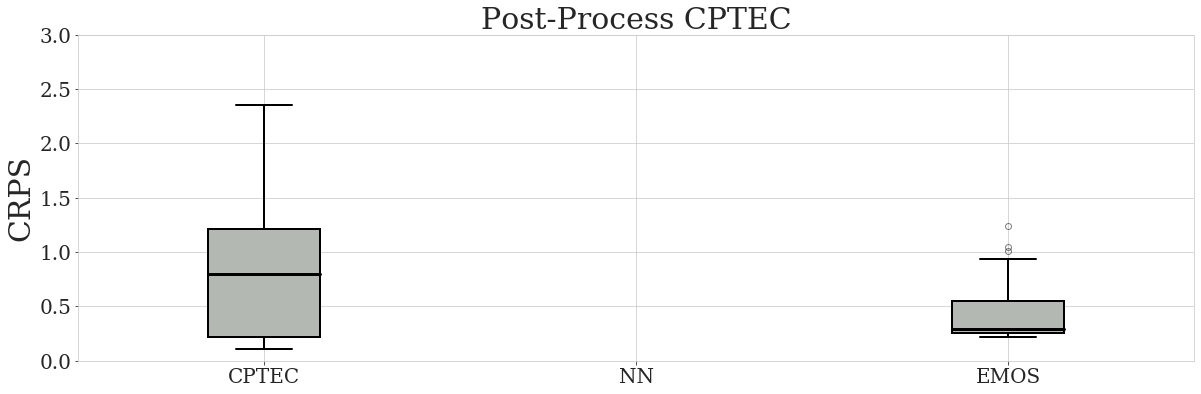

In [53]:
data_to_plot=[crps_m,crps_p,crps_e]


fig = plt.figure(1, figsize=(20, 6))

# Create an axes instance
ax = fig.add_subplot(111)
## add patch_artist=True option to ax.boxplot() 
## to get fill color
bp = ax.boxplot(data_to_plot, patch_artist=True)

## change outline color, fill color and linewidth of the boxes
for box in bp['boxes']:
    # change outline color
    box.set( color='k', linewidth=2)
    # change fill color
    box.set( facecolor = [0.7,0.72,0.7] )

## change color and linewidth of the whiskers
for whisker in bp['whiskers']:
    whisker.set(color='k', linewidth=2)

## change color and linewidth of the caps
for cap in bp['caps']:
    cap.set(color='k', linewidth=2)

## change color and linewidth of the medians
for median in bp['medians']:
    median.set(color='k', linewidth=3)

## change the style of fliers and their fill
for flier in bp['fliers']:
    flier.set(marker='o', color='k', alpha=0.5)
    
plt.ylim([0,3])
ax.set_xticklabels(['CPTEC','NN','EMOS'],fontsize=20)
ax.set_yticklabels(np.arange(0,3.5,0.5),fontsize=20)
plt.ylabel('CRPS',fontsize=30)


ax.get_xaxis().tick_bottom()
ax.get_yaxis().tick_left()

plt.title('Post-Process CPTEC',fontsize=30)
plt.show()
